In [1]:
%%capture
#from __future__ import print_function
#import pandas
#from pathlib import Path
#import os.path
import time
#import os
import numpy as np
import matplotlib.pyplot as plt
import cyipopt
from cyipopt import minimize_ipopt
from phe import paillier
#from array import array
#import matplotlib.pyplot as plt
import time

start_time = time.time();

public_key, private_key = paillier.generate_paillier_keypair(n_length=128)
d1=8
l1=28
l2=36#l2>=l1+d1
Q_l = -2**(l1-d1-1);
Q_u = 2**(l1-d1-1) - 2**(-d1);
def quant1(val):
    return np.fmin(np.fmax(np.round(val/(2**(-d1)))*(2**(-d1)),Q_l),Q_u)
def quant2(val):
    return int((2**d1)*val%(2**l2))
def quant3(val):
    return np.where((val%(2**l2))>=(2**(l2-1)),(val%(2**l2)) - (2**l2),(val%(2**l2)))/(2**d1)
    
######### Simulation time #########################

delta               = 1e-2                               #hr Sampling Time
hc                  = 1e-4                               #hr Numerical Integration Step Size
tFinal              = 1                                  #hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps         = int(tFinal / hc )                    # Number of calculated steps
integrationTimeSteps = int(delta  / hc )                    # Number of steps per horizon  
controlTimeSteps     = 5                                   # Number of times Sensor data is read
#NUM_MPC_ITERATION    = int(tFinal/(delta*controlTimeSteps)) # Number of times simulation is run
NUM_MPC_ITERATION    = int(tFinal / delta ) # Number of times simulation is run

NUM_OUTPUTS          = 2                                    # Model Outputs: x1 x2 
NUM_INPUTS           = 4                                    # Model  Inputs: u1 u2 x1 x2
NUM_U                = int(NUM_INPUTS-NUM_OUTPUTS)          # Number of control inputs



NUM_MPC_INPUTS      = int(NUM_U*controlTimeSteps)            # 1 set of control inputs per Horizon 
NUM_MPC_CONSTRAINTS = controlTimeSteps                       # Constraints must be satisfied at all points

################### P matrix #############################
#V= xTP(x) "Energy of Sys"

a = 1060 
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
#Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
#Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
A1 = np.array([1, 0.99, 1.01, 0.98, 1.02])
A2 = np.array([17, 14, 5, 7, 9])
A3 = np.array([1e-8, 0.8*1e-8, 0.84*1e-8, 0.9*1e-8, 0.92e-8])

#################### PI Controler Weights ###########
proportionalGainConcentration = 10
proportionalGainHeat          = 10000
integralGain                  = 0.01

##################### initial values and initializations ######################

#Initial Values in Deviation Variable Form
CA_real         = 1.75 #kmol/m3
T_real          = -40 #K

x_record        = np.zeros((NUM_OUTPUTS,NUM_MPC_ITERATION+1))
x_real   = np.array([[CA_real],[T_real]])
x_record[:,[0]] = x_real



u_record        = np.zeros((NUM_U,NUM_MPC_ITERATION))
offset_record   = []
grad_f_record   = []
cost_record     = []

V_record        = []
CostFun         = []
status_record   = []

realtime_data   = None
cost            = 0.0

################################ Parameters ######################

#Flowrate Terms
F      = 5       #m^3/hr
V      = 1       #m^3

#Thermochemical Properties
rhoe_L = 1e3     #kg/m3
Cp     = 0.231   #kJ/kg-K
deltaH = -1.15e4 #kJ/kmol
E      = 5e4     #kJ/kmol
R      = 8.314   #kJ/kmolK 
k0     = 8.46e6  #m3/kmol-h

#Thermal Properties
T0     = 300     #K

###################Simplifications################################
E_over_R = -E/R                       #K
Coeff1   = (F/V)
Coeff2   = ((deltaH*k0)/(rhoe_L*Cp))
Coeff3   = (V*rhoe_L*Cp)
######################## steady state values ########################
#Invariant Parameters
T0s  = 300          #K

#State Variables
CAs  = 1.954        #kmol/m3
Ts   = 401.9        #K

#Control Variables
Qs   = 0.0          #kJ/hr
CA0s = 4            #kmol/m3

#################################################
################## MPC PROGRAM ##################
#################################################
#def equalityConstraints(x):#f(x) + C= 0
#    return np.sum(x**2) - 40 
#def inequalityConstrains(x):#f(x) + C >= 0
#    return np.prod(x) - 25  
#cons = [
#    {'type': 'eq', 'fun': equalityConstraints, 'jac': equalityConstraints_Jacobian, 'hess': equalityConstraints_Hessian},
#    {'type': 'ineq', 'fun': inequalityConstrains, 'jac': inequalityConstrains_Jacobian, 'hess': inequalityConstrains_Hessian}
# ] 
############################################################################################################
##################################### Cost Function#########################################################
############################################################################################################
def eval_f(u):#L=xQx+uRu
    #print("eval_f:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    #Define initial Guesses
    offset = 0
    x      = x_real
    
    #Define the initial values of the State Variables
    CA  = x.item(0)
    T   = x.item(1)
    #print('X is ',x)
    #print('U is ',u)
    ##Numerical Integration
    ### check how to write the inputs
    for jj in range(controlTimeSteps):
        #Define the initial values of the Control Variables
        CA0 = u.item(NUM_U*jj+0)
        Q   = u.item(NUM_U*jj+1)
        for jjj in range(integrationTimeSteps):#Newtons Method x=u, x1&x2 = x
            
            #Define the final values of the State Variables
            CA  = x.item(0)
            T   = x.item(1)
            

            #Functions shown before converting to Deviation Variable Form
            #fun_1= (F/V)*(CA0)-(F/V)*(CA1)-k0*np.exp(E_over_R/(T))*(CA1)**2
            #fun_2= (F/V)*(T0)-(F/V)*(T)-((deltaH*k0)/(rhoe_L*Cp))*np.exp(E_over_R/(T))*(CA1)**2+(Q)/(rhoe_L*Cp*V)
            #Coeff1=(F/V)
            #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
            #Coeff3=(V*rhoe_L*Cp)
            #CA,T,CA0, and Q are in deviation variable form
            #T0 is not in deviation variable form      
    
            fun_1 = Coeff1*(CA0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2
            fun_2 = Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(Q)/Coeff3
            
            #Use Newtons Method to iterate
            #x1Dot = fun_1 and so on
            x     = x + hc*np.array([[fun_1],[fun_2]])  
        #Define the final values of the State Variables
        CA  = x.item(0)
        T   = x.item(1)    
        ##Sum the Cost Function over every HORIZON
        offset = offset -k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2
    #print('f=',offset*delta)
    return offset*delta

##################################### Cost Function Derivative ###############################################

def eval_grad_f(u):#Finite difference approximation of df/du
    #print("eval_grad_f:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    step = 1.e-3 # we just have a small step
    objp=objm=0
    grad_f = [0]*NUM_MPC_INPUTS
    upstep = [0]*NUM_MPC_INPUTS
    umstep = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        upstep=u.copy()
        umstep=u.copy()
        # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
        upstep[i_mpc_input]  = upstep[i_mpc_input]+step 
        umstep[i_mpc_input] = umstep[i_mpc_input]-step
        #print ("step: ", step)
        #print ("up:  ",upstep)
        #print ("um:  ",umstep)
        #print ("i_mpc_input:  ",i_mpc_input)
        # Evaluate the objective function at upstep and umstep
        objp=eval_f(upstep) # This function returns the value of the objective function evaluated with the variable u[i] is perturebed +step
        objm=eval_f(umstep) # This function returns the value of the objective function evaluated with the variable u[i] is perturebed -step
        #print ("obj ", objp, "   objm   ", objm)
        grad_f[i_mpc_input] = (objp - objm) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable x[i]
    #print("Gradient: ", grad_f)
    
    grad_f_record.append(grad_f)
    return np.array(grad_f)

############################################################################################################
##################################### Constraints ##########################################################
############################################################################################################
def eval_g(u):#V condition, Vdot condition, the Energy constraint
    #print("eval_g:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    g = np.array([-1.0]*(controlTimeSteps))  #Default to <0 i.e valid
    
    #LMPC Controller Version 
    #Define the initial values of the State Variables
    x=x_real
    CA=x.item(0)
    T=x.item(1)
    #If V=x*P*x, then Vdot=2x*P*f + 2x*P*g*u         
    #Recall that xDot=f+g*u
    #Recall further that P is of the form= [a,b;b,d]
    #Explicitly, this gives: (make sure all instances of u are replaced with 0)
    #In this system, u=CA0 and Q
    #LfV = (2 * a * CA1 + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
    #      (2 * d * T + 2 * b * CA1) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 ) + \
    #All the Q terms are instead moved here
    #Lg1V= (2 * a * CA1 + 2 * b * T)*Coeff1
    #Lg2V = (2 * d * T + 2 * b * CA1) / Coeff3
    #Coeff1=(F/V)
    #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
    #Coeff3=(V*rhoe_L*Cp)
    #Note that if its known that LfV cancels you can just set it equal to 0   
    
    #LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
    #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
    LfV = 0
    Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
    Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
    
    #xdot = F = f(x) + g(x)u
    #Vdot = LfV(x)+LgV(x)*u      
    dV_op2=LfV+Lg1V*u.item(0)+Lg2V*u.item(1) #Using EMPC
    
    #using P controller [Backup controller{We want LEMPC to be better than this}]
    ###########Not Defined for system yet
    kc1 = 2
    kc2 = 12000
    u11= kc1*(0-CA)
    u22= kc2*(0-T)
    dV_Pu2=LfV+Lg1V*u11+Lg2V*u22 #Using Backup Controller
    
    #If g is negative, EMPC is smaller than the Backup Controler{Better}
    #We use g as an array in case there are multiple controllers used as constraints
    V_secure=90
    V_predicted=(a*CA**2) + 2*(b*CA*T) + (d*T**2)

    #print('Xg is ',x)
    #print('Ug is ',u)       
    if V_predicted<=V_secure:
        for controlIteration in range(controlTimeSteps):
            #Define the initial values of the Control Variables
            CA0 = u.item(NUM_U*controlIteration+0)
            Q   = u.item(NUM_U*controlIteration+1)
            for _ in range(integrationTimeSteps):#Newtons Method x=u, x1&x2 = x
                #Define the initial values of the State Variables
                CA  = x.item(0)
                T   = x.item(1)             
                
                #Functions shown before converting to Deviation Variable Form
                #fun_1= (F/V)*(CA0)-(F/V)*(CA1)-k0*np.exp(E_over_R/(T))*(CA1)**2
                #fun_2= (F/V)*(T0)-(F/V)*(T)-((deltaH*k0)/(rhoe_L*Cp))*np.exp(E_over_R/(T))*(CA1)**2+(Q)/(rhoe_L*Cp*V)
                #Coeff1=(F/V)
                #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
                #Coeff3=(V*rhoe_L*Cp)
                #CA,T,CA0, and Q are in deviation variable form
                #T0 is not in deviation variable form      
        
                fun_1 = Coeff1*(CA0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2
                fun_2 = Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(Q)/Coeff3
                
                #Use Newtons Method to iterate
                #x1Dot = fun_1 and so on
                x     = x + hc*np.array([[fun_1],[fun_2]])  
            #Define the initial values of the State Variables
            CA  = x.item(0)
            T   = x.item(1) 
            #print('CA is ',CA)
            #print('T is ',T)
            g[controlIteration]=((a*CA**2) + 2*(b*CA*T) + (d*T**2)) - V_secure
    else:
        g[0]=dV_op2 - min(0,dV_Pu2-0.000065) #Difference of MPC and P, Vdot
    
    # # Material constraint
    # material_used = np.sum(u_record[[0],:])
    # if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
    #     for controlIteration in range(controlTimeSteps):
    #         material_used = material_used + u.item(NUM_U*controlIteration+0)
    # else:
    #     for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
    #         material_used = material_used + u.item(NUM_U*controlIteration+0)
    # g[-1] = 0 - material_used
    #print("-g is ", -g)
    return -g


##################################### Constraints Derivative ##########################################################
def equalityConstraints(u):#f(x) + C= 0
    #print("equalityConstraints:",u)
    # Material constraint
    material_used = np.sum(u_record[0])
    if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
        for controlIteration in range(controlTimeSteps):
            material_used = material_used + u.item(NUM_U*controlIteration+0)
    else:
        for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
            material_used = material_used + u.item(NUM_U*controlIteration+0)
    #print("past u is ",np.sum(u_record[0]))
    #print("u is ",u)
    #print("material_used is ", material_used)
    return material_used - 1
def eval_jac_g(x):
    #print("eval_jac_g:",x)
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1e-1 # we just have a small step
    gp=gm=np.zeros(NUM_MPC_CONSTRAINTS)
    xpstep=xmstep=np.zeros(NUM_MPC_INPUTS)
    jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
    #print ("shape:", jac_g)
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        xpstep[i_mpc_input] += step
        xmstep[i_mpc_input] -= step
        gp=eval_g(xpstep)
        gm=eval_g(xmstep)
        for num_constraint in range(NUM_MPC_CONSTRAINTS):
            jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)
    return np.array(jac_g)
############################################################################################################
############################################################################################################
############################################################################################################
cons = [
   {'type': 'eq', 'fun': equalityConstraints},
   {'type': 'ineq', 'fun': eval_g, 'jac': eval_jac_g}
]
u_L=[]
u_U=[]
lowerBounds=[-3.5,-5e5]
upperBounds=[3.5 ,5e5]
for _ in range(controlTimeSteps):
    u_L=u_L+lowerBounds
    u_U=u_U+upperBounds                                       
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Running Main Code Loop")
print("Number of times IPOPT will be called= ",NUM_MPC_ITERATION)
print("Number of Horizons[Sensor Data Readings] = ",controlTimeSteps)
print("Number of time steps per Horizon = ",integrationTimeSteps)
print("Number of State Variables = ",NUM_OUTPUTS)
print("Number of Control Inputs = ",NUM_U)
print("Size of u matrix = ",NUM_MPC_INPUTS)
print("Number of MPC Constraints = ",NUM_MPC_CONSTRAINTS)
for main_iteration in range(NUM_MPC_ITERATION):
    x = x_real
    CA = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(x.item(0))))))
    T = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(x.item(1))))))
    #####     Print Current Iteration Info     #####
    print('\n\n\n')
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print ("Iteration #", main_iteration+1)
    print("Current Un-Quantized State Variable Values: CA = ",x.item(0),", T = ",x.item(1),"K")
    print("Current State Variable Values: CA = ",CA,", T = ",T,"K")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    
    
    #####        Set-up control inputs         #####
    if main_iteration==0:
        uUnoptimized = np.array([0]*NUM_MPC_INPUTS) #which are u1 and u2 [Initialize blank array]
    else:
        uUnoptimized=u    
        #Shift control inputs over 1 horizon
        #Last horizon is duplicated, but this is ok as we only sample and hold for 1 horizon
        uUnoptimized = np.array([0.0]*NUM_MPC_INPUTS) # REMOVE LATER   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA!!!!!!!!!
        uUnoptimized[0:-NUM_U] = u[NUM_U:]
    for i in range(len(uUnoptimized)):
        uUnoptimized[i] = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(uUnoptimized[i])))))
    print("The value of u before optimization is ", uUnoptimized)
    #Set up and solve optimization problem via IPOPT
    print("Solving IPOPT...")
    start_time_IPOPT  = time.time();
    soln = minimize_ipopt(eval_f, jac=eval_grad_f, x0=uUnoptimized, bounds=bnds,constraints=cons, options={'maxiter':500,'tol': 1e-4})
    end_time_IPOPT = time.time();
    total_runtime_IPOPT = end_time_IPOPT - start_time_IPOPT;
    print("Total time required to solve via IPOPT = %f seconds " % total_runtime_IPOPT)
    print("IPOPT Closed.")
    print(soln)
    
    #Print IPOPT Results
    u=soln.x
    for i in range(len(u)):
        u[i] = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(u[i])))))
    print("Optimized u values are:",u)
    
    #Define the initial values of the Control Variables
    CA0 = u.item(0)
    Q   = u.item(1)
    u_record[:,[main_iteration]]=np.array([[CA0],[Q]])
    for _ in range(integrationTimeSteps):#Newtons Method x=u, x1&x2 = x
        
        #Define the final values of the State Variables
        CA  = x.item(0)
        T   = x.item(1)
        

        #Functions shown before converting to Deviation Variable Form
        #fun_1= (F/V)*(CA0)-(F/V)*(CA1)-k0*np.exp(E_over_R/(T))*(CA1)**2
        #fun_2= (F/V)*(T0)-(F/V)*(T)-((deltaH*k0)/(rhoe_L*Cp))*np.exp(E_over_R/(T))*(CA1)**2+(Q)/(rhoe_L*Cp*V)
        #Coeff1=(F/V)
        #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
        #Coeff3=(V*rhoe_L*Cp)
        #CA,T,CA0, and Q are in deviation variable form
        #T0 is not in deviation variable form      

        fun_1 = Coeff1*(CA0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2
        fun_2 = Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(Q)/Coeff3
        
        #Use Newtons Method to iterate
        #x1Dot = fun_1 and so on
        x     = x + hc*np.array([[fun_1],[fun_2]])  
    #Define the final values of the State Variables
    CA  = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(x.item(0))))))
    T   = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(x.item(1))))))
    #x_real = np.array([[CA],[T]]) 
    x_real = x
    x_record[:,[main_iteration+1]]= x_real
    ##Sum the Cost Function over every HORIZON
    cost_record.append((-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2)*delta)
t=np.linspace(0,tFinal,int(tFinal/delta)+1)

plt.plot(t,x_record[0,:],'k',label='CA')
plt.legend()
plt.show()

plt.step(t[:-1],u_record[0,:],'r',label='CA0',where='post')
plt.legend()
plt.show()

plt.plot(t,x_record[1,:],'k',label='T')
plt.legend()
plt.show()

plt.step(t[:-1],u_record[1,:],'r',label='Q',where='post')
plt.legend()
plt.show()

end_time = time.time();

total_runtime = end_time - start_time;

print("Total time required to execute the code = %f seconds " % total_runtime)

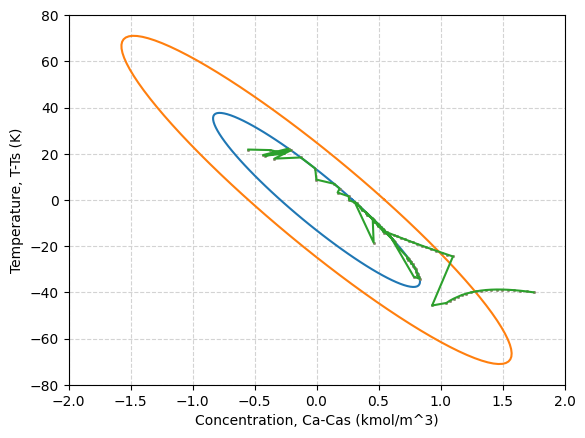

In [2]:
import numpy as np
import pickle, os
from matplotlib import pyplot as plt
from math import pi, cos, sin
#plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -90
A2, B2, C2, F2 = 1060, 44, 0.52, -320
angle = 0.5*np.arctan(B/(A-C)) # rotation angle
A_prime = A*(cos(angle))**2 + B*cos(angle)*sin(angle) + C*(sin(angle))**2
C_prime = A*(sin(angle))**2 - B*cos(angle)*sin(angle) + C*(cos(angle))**2
a = np.sqrt(-F/A_prime) # radius on the x-axis
b = np.sqrt(-F/C_prime) # radius on the y-axis
C_A_limit = np.sqrt(a**2*(cos(angle))**2+b**2*(sin(angle))**2)
T_limit = np.sqrt(a**2*(sin(angle))**2+b**2*(cos(angle))**2)

A_prime2 = A2*(cos(angle))**2 + B2*cos(angle)*sin(angle) + C2*(sin(angle))**2
C2_prime = A2*(sin(angle))**2 - B2*cos(angle)*sin(angle) + C2*(cos(angle))**2
a2 = np.sqrt(-F2/A_prime2) # radius on the x-axis
b2 = np.sqrt(-F2/C2_prime) # radius on the y-axis
C_A_limit = np.sqrt(a**2*(cos(angle))**2+b**2*(sin(angle))**2)
T_limit = np.sqrt(a**2*(sin(angle))**2+b**2*(cos(angle))**2)

u,v = 0, 0 # Unstable

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)]) #u,v removed to keep the same center location
R_rot = np.array([[cos(angle) , -sin(angle)],[sin(angle) , cos(angle)]]) #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    
Ell2 = np.array([a2*np.cos(t) , b2*np.sin(t)]) #u,v removed to keep the same center location
R_rot2 = np.array([[cos(angle) , -sin(angle)],[sin(angle) , cos(angle)]]) #2-D rotation matrix

Ell_rot2 = np.zeros((2,Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:,i] = np.dot(R_rot2,Ell2[:,i])

plt.plot(u+Ell_rot[0,:], v+Ell_rot[1,:])
plt.plot(u+Ell_rot2[0,:], v+Ell_rot2[1,:])# Rotated ellipse
for i in range(10):
    plt.plot(x_record[0,:], x_record[1,:], 'o', alpha=0.2,markersize=1)
plt.plot(x_record[0], x_record[1])
plt.grid(color='lightgray',linestyle='--')
plt.xlim(-2,2)
plt.ylim(-80,80)
plt.xticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
plt.yticks([-80,-60,-40,-20,0,20,40,60,80])
plt.xlabel('Concentration, Ca-Cas (kmol/m^3)')
plt.ylabel('Temperature, T-Ts (K)')
plt.savefig('ellipse.pdf')

In [3]:
sum(-k0*np.exp(E_over_R/(x_record[1]+Ts))*(x_record[0]+CAs)**2)*delta

-9.422750415222298

In [4]:
-5e5 - -2**(28-8-1)

24288.0

In [5]:
np.fmin(1.07619830e+05*np.ones((2,2)),Q_l)

array([[-524288., -524288.],
       [-524288., -524288.]])

In [6]:
import numpy
import time
from phe import paillier

In [7]:
# Quantization functions
l1 = 28 #l1 - d1 = constant =16; Thus l1 =15+d1
l2 = 32 #l2 > l1
d1= 8
Q_l =-2**(l1-d1-1)
Q_u = 2**(l1-d1-1) - 2**(-d1)

#Defining the lower limit and upper limit of the set Q containing all the quantized parameters, creating it through for loop.
Q_ll = -2**(l1-d1-1);
Q_ul = 2**(l1-d1-1) - 2**(-d1);
res = 2**(-d1)

num_elem = int((Q_ul - Q_ll)/res + 1);
Q = numpy.zeros(num_elem)
Q[0] = Q_ll;
Q[num_elem-1] = Q_ul;

iter_count_q = 0;
iter_count_search = 0;

for i in range(1,num_elem-1):    
    Q[i] = Q[i-1] + res;
    iter_count_q = iter_count_q + 1;

#binary search; Begin by finding the midpoint of the array created. 2 Cases- even, odd.
ll = 0;
ul = num_elem - 1;

if((ul - ll)%2 == 0):
    mid_point = int((ul - ll)/2);    
if((ul - ll)%2 != 0):
    mid_point =  int((ul - ll + 1)/2);

it_val = 10;
counter_q = 0;
total_time_search=0;
iter_count_search =0;
single_iter_count_search_record=[]

#Creating a function to output a quantized state  
def quant1(x1,Q,mid_point,ll,ul,it_val,counter_q,iter_count_search):#x to Q
    iter_count_search =0;
    while(it_val>0):
        if((ul - ll) == 1):
            break;
        if(x1 > Q[mid_point]):
            ll = mid_point;    
        if(x1 < Q[mid_point]):
            ul = mid_point;
        #exactly midpoint, success quantized 
        if(x1 == Q[mid_point]):
            x1_q1 = Q[mid_point]
            counter_q = counter_q + 1;
            break;
            #Update mid point for next iter
        if((ul - ll)%2 == 0):
            mid_point = ll + int((ul - ll)/2);
        if((ul - ll)%2 != 0):
            mid_point =  ll + int((ul - ll + 1)/2);    
        iter_count_search = iter_count_search + 1;  
    #if true, no midpoint was equal to x1, no exact match
    if(counter_q == 0):
        if(abs(x1 - Q[ul]) < abs(x1 - Q[ll])):
            x1_q1 = Q[ul];
        if(abs(x1 - Q[ul]) == abs(x1 - Q[ll])):
            if(abs(Q[ul]) < abs(Q[ll])):
                x1_q1 = Q[ul];    
            else:
                x1_q1 = Q[ll];       
        if(abs(x1 - Q[ul]) > abs(x1 - Q[ll])):
            x1_q1 = Q[ll];
    single_iter_count_search_record.append(iter_count_search)
    return x1_q1

def newquant1(val):
    return numpy.fmin(numpy.fmax(numpy.round(val/(2**(-d1)))*(2**(-d1)),Q_l),Q_u)

print(quant1(-1e5,Q,mid_point,ll,ul,it_val,counter_q,iter_count_search))
print(newquant1(-1e5))

-100000.0
-100000.0


In [8]:
(-k0*np.exp(E_over_R/(x_record[1]+Ts))*(x_record[0]+CAs)**2)*delta

array([-0.07042532, -0.06958624, -0.06855805, -0.06741421, -0.06611209,
       -0.06464701, -0.06301672, -0.06121452, -0.05925144, -0.05712787,
       -0.05486176, -0.05247414, -0.04998221, -0.04742387, -0.04496797,
       -0.04236619, -0.03980763, -0.03732457, -0.03277408, -0.09483451,
       -0.09526589, -0.09567664, -0.09606708, -0.09643757, -0.09678852,
       -0.09712095, -0.09743532, -0.0977321 , -0.09801177, -0.09827484,
       -0.09852181, -0.09875319, -0.09896951, -0.0991713 , -0.09935909,
       -0.09953341, -0.1069316 , -0.13352668, -0.07601997, -0.11420095,
       -0.09558877, -0.08877566, -0.08268813, -0.07188937, -0.0707143 ,
       -0.07051039, -0.06929137, -0.06893775, -0.06813226, -0.06726766,
       -0.06595564, -0.06532505, -0.06429216, -0.06320185, -0.06205535,
       -0.06081915, -0.05956518, -0.05796861, -0.05676976, -0.05481413,
       -0.05362982, -0.05187242, -0.05227971, -0.09157876, -0.12102001,
       -0.09721294, -0.10307995, -0.08918874, -0.09548928, -0.09

In [9]:
sum(u_record[0])

1.0